# Identifying Locations with High Growth Potential

 
### Overview
Our objective is to identify areas across the country with high growth potential for life insurance sales. Current tools in the market can provide underlying data, but they rely on users to perform their own analysis, and the software can be costly.

To address this problem, we use publicly available tax data and a deep learning algorithm to generate a growth index. This index effectively identifies areas with the highest growth potential for life insurance sales.

### Source Data
We are using a publicly available data set: Individual income tax data by zip code, available from the [IRS Website](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). This data contains information such as number of joint returns, number of dependents, salaries & wages, and number of returns with property taxes. The data is split by state, zip code, and adjusted gross income (AGI) bucket.

### Predictive Model
To create a growth index by zip code and AGI bucket, we need to project the number of returns, number of dependents, etc. over the next several years. To do so, we need a regression algorithm that is specific to each zip code and AGI bucket. There are about 80,000+ combinations of zip code and AGI bucket in the U.S., so creating 80,000+ regressions can be computationally intensive. Therefore, we utilize a deep learning algorithm which has some advantages:
- Traditional regression algorithms have improved performance by carefully selecting and designing input variables. The performance of a deep learning algorithm is less dependent on variable selection and design due to the complex, non-linear nature of the algorithm.
- For cohorts with sparse data, it will rely on aggregate trends to supplement credibility gaps.
- The run time and model performance is superior to creating individual regression models for each cohort.
- Multiple output variables can be modeled simultaniously in the same model


--------------------------------------------------------------

## Beginning of Code

We start by importing the necessary libraries for the model. We will be using the Keras library for the deep learning algorithm. Note that we are using Python and Keras versions 3.7.3 and 2.2.4 respectively.

In [1]:
#Import Libraries
import csv
import itertools
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import regularizers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Activation, BatchNormalization

Using TensorFlow backend.


## Data Preprocessing - Part 1

In the next code block, we load data for years 2009 - 2016. The data can be downloaded from the [IRS Website](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). To effectively run the code, extract the csv files for each year in the same folder as this python notebook. We have included state and AGI bucket filters to illustrate the model capabilities while managing run time.

Seven fields are plucked from the data sets:
1. State
2. Zip Code
3. AGI Cohort
4. Number of joint returns - represents households with married couples
5. Number of dependents - represents households with children
6. Income and Wages - represents financial health
7. Number of returns with real estate taxes - represents home ownership

Fields 1-3 are model inputs and fields 4-7 are the outputs. These outputs are associated with life events which are key drivers of life insurance sales, based on an [article published by Deloitte](https://www2.deloitte.com/insights/us/en/industry/financial-services/marketing-life-insurance-in-a-digital-age.html )

In the subsequent code block, we remove zip codes "00000" which represent totals for each state, and "99999" which are unknown zip codes.

In [2]:
#read in file names and append values of specific columns to rows of array
filename_list = ['09zpallagi.csv','10zpallagi.csv','11zpallagi.csv','12zpallagi.csv','13zpallagi.csv','14zpallagi.csv','15zpallagi.csv','16zpallagi.csv']
year_list = ['2009','2010','2011','2012','2013','2014','2015','2016']
state_list = ['NV']
agi_filter = ['4']
data = []
file_count = 0

#Lowercase keys in Python Dictionaries
def lower_first(iterator):
    return itertools.chain([next(iterator).lower()],iterator)

def load_data(filename, year):
    with open(filename) as taxinput_file:
        reader = csv.DictReader(lower_first(taxinput_file))
        for row in reader:
            if row['state'] in state_list and row['agi_stub'] in agi_filter:
                data.append([row['zipcode'].zfill(5),row['agi_stub'],year,row['mars2'],row['numdep'],row['a00200'],row['n18500']])
    return;

for file in filename_list:
    load_data(file, year_list[file_count])
    file_count += 1

In [3]:
# Strip out the zip codes "00000" (Totals for each state) and "99999" (unknown zip codes/not reported
data_clean = []

for row in data:
    if row[0]=='00000' or row[0]=='99999':
        continue
    else:
        data_clean.append(row)

## Data Preprocessing - Part 2

We continue preprocessing the data by splitting it into separate train and test data sets. The test data set allows us to identify when overfitting is occuring, and we apply an L2 regularization parameter to compensate. Notice that the training data is based on years 2009-2015, and the test data is based on 2016. We chose this approach instead of a random sampling because the model's objective is optimize extrapolation of data points instead of interpolation and extrapolation.

Then, we create a unique list of all zip codes and remove data set records where zip codes were newly created or removed throughout time. This provides a cleaner basis for the data.

In [4]:
#Split data between test and train
train_year = ['2009','2010','2011','2012','2013','2014','2015']
train_data = []
test_data = []

for row in data_clean:
    if row[2] in train_year:
        train_data.append(row)
    else:
        test_data.append(row)

train_data = np.array(train_data)
test_data = np.array(test_data)

In [5]:
#Create a unique list of zip codes and filter to include only zip codes in all years
unique_zipcode_list = []

for row in train_data:
    if row[2] == train_year[0] and row[0] not in unique_zipcode_list:
        unique_zipcode_list.append(row[0])
    else:
        continue

for zipcode in unique_zipcode_list:
    if zipcode not in train_data[:,0] or zipcode not in test_data[:,0]:
        unique_zipcode_list.remove(zipcode)
    else:
        continue

In [6]:
#Delete records from the training data with zip codes not in the unique zip code list
filter_list = []
row_count = 0

for row in train_data:
    if row[0] in unique_zipcode_list:
        filter_list.append(row_count)
    row_count += 1

train_data = train_data[filter_list]

In [7]:
#Delete records from the training data with zip codes not in the unique zip code list
filter_list = []
row_count = 0

for row in test_data:
    if row[0] in unique_zipcode_list:
        filter_list.append(row_count)
    row_count += 1
    
test_data = test_data[filter_list]

## Data Preprocessing - Part 3

The next three code blocks perform the following functions:

1. We shuffle the data to improve mini-batch gradient descent performance
2. Columns are split into input variables (x) and output variables (y)
3. Output variables are normalized to improve training performance
4. Zip codes are nominal variables (the order does not matter). Deep learning algorithms perform significantly better if nominal values are one-hot encoded. This means creating a separate column for each zip code with a binary indicator (1 or 0) for each row where the zip code is applicable.

In [8]:
#Shuffle training data by row and split input and output for use in model
row = np.random.choice(train_data.shape[0], train_data.shape[0], replace = False)
train_data = train_data[row]

x_columns = 3
y_columns = train_data.shape[1]

x_train = train_data[0:,0:x_columns]
y_train = np.array(train_data[0:,x_columns:y_columns], dtype=float)
x_test = test_data[0:,0:x_columns]
y_test = np.array(test_data[0:,x_columns:y_columns], dtype=float)

In [9]:
#Normalize Output Variables
y_train_mean = np.mean(y_train, axis=0)
y_train_stdev = np.std(y_train, axis=0)

y_train_norm = np.divide(y_train - y_train_mean, y_train_stdev)
y_test_norm = np.divide(y_test - y_train_mean, y_train_stdev)

In [10]:
#One hot encode training data
x_train_encode = np.zeros((x_train.shape[0],len(unique_zipcode_list)))
unique_zipcode_list = np.array(unique_zipcode_list)

for row in range(x_train.shape[0]): 
    x_train_encode[row,x_train[row,0]== unique_zipcode_list] = 1

x_train_encode = np.array(np.append(x_train_encode,x_train[0:,1:3],axis = 1), dtype=float)

In [11]:
#One hot encode test data
x_test_encode = np.zeros((x_test.shape[0],len(unique_zipcode_list)))
unique_zipcode_list = np.array(unique_zipcode_list)

for row in range(x_test.shape[0]): 
    x_test_encode[row,x_test[row,0]== unique_zipcode_list] = 1
    
x_test_encode = np.array(np.append(x_test_encode,x_test[0:,1:3],axis = 1), dtype=float)

## Building and Training the Model
- We clear any parameters that may have been run previously.
- We defined the deep network architecture using the `model.add` method from Keras
   - `BatchNormalization()` at the start and between layers normalizes inputs for faster training
   - The model has 4 hidden layers with 100, 50, 25, 10 activation nodes respectively. 
   - Each hidden layer uses a rectified linear unit (ReLU) activation function. This returns a linear function for positive parameters, and zero for negative parameters.
   - The model has an output layer with 4 linear regression outputs. The deep learning algorithm allows us to model all four target output variables simultaniously instead of needing 4 separate models.
   - The model employs L2 regularization in each layer, and the regularization parameter has been tuned to reduce overfitting in the output.
- For the model optimizer, we are using Adam optimization, a variant of gradient descent
- Since the output layer is linear, we decided to use mean squared error for the loss function
- The model is trained using mini-batches (runs 5,000 records at a time), and 20,000 epochs (full iterations of the data set)

In [16]:
#Clear weights between model runs
keras.backend.clear_session()

In [17]:
#Deep Learning Model
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.2)))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.2)))
model.add(BatchNormalization())
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.2)))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.2)))
model.add(BatchNormalization())
model.add(Dense(4,kernel_regularizer=regularizers.l2(0.2)))

In [18]:
#Loss Function
adam_opt = keras.optimizers.Adam(lr=0.001,beta_1=0.99)
model.compile(optimizer = adam_opt, loss='mean_squared_error')

In [19]:
#Train Model (takes < 5 minutes to run)
print("Starting Loss="+str(round(model.evaluate(x_train_encode, y_train_norm, verbose = 0),7)))

for i in range(20):
    model.fit(x_train_encode, y_train_norm, verbose = 0, epochs = 1000, batch_size = 5000)
    print("Epoch "+str((i+1)*1000)+" complete : Train_Loss="+
          str(round(model.evaluate(x_train_encode, y_train_norm, verbose=0),7))+
         " : Test_Loss:" + str(round(model.evaluate(x_test_encode, y_test_norm, verbose=0),7)))
    i += 1

print("")
print("Test set loss: " + str(model.evaluate(x_test_encode, y_test_norm, verbose=0)))

Starting Loss=1082.6692254
Epoch 1000 complete : Train_Loss=0.1271545 : Test_Loss:0.1467361
Epoch 2000 complete : Train_Loss=0.0538417 : Test_Loss:0.0715677
Epoch 3000 complete : Train_Loss=0.0412756 : Test_Loss:0.0589698
Epoch 4000 complete : Train_Loss=0.0324949 : Test_Loss:0.051852
Epoch 5000 complete : Train_Loss=0.0278636 : Test_Loss:0.0448968
Epoch 6000 complete : Train_Loss=0.0240046 : Test_Loss:0.0397897
Epoch 7000 complete : Train_Loss=0.0207874 : Test_Loss:0.0350065
Epoch 8000 complete : Train_Loss=0.1340252 : Test_Loss:0.1298236
Epoch 9000 complete : Train_Loss=0.0159977 : Test_Loss:0.0284639
Epoch 10000 complete : Train_Loss=0.0151543 : Test_Loss:0.0269539
Epoch 11000 complete : Train_Loss=0.0146448 : Test_Loss:0.0256589
Epoch 12000 complete : Train_Loss=0.1179967 : Test_Loss:0.1353134
Epoch 13000 complete : Train_Loss=0.0052528 : Test_Loss:0.0139628
Epoch 14000 complete : Train_Loss=0.0053809 : Test_Loss:0.013802
Epoch 15000 complete : Train_Loss=0.0065301 : Test_Loss:0.01

## Model Summary
The next cell provides a summary of the deep network architecture. Notice that ***20,155*** parameters are being trained! This is how the model is able to create regression functions for all the different zip code and AGI bucket cohorts.

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
batch_normalization_4 (Batch (None, 25)                100       
__________

## Visualizing a Sample Zip Code
The following code block creates a graph for a sample zip code. Notice how the model is able to effectively trend each of the output variables from 2017 through 2020.

<function matplotlib.pyplot.show(*args, **kw)>

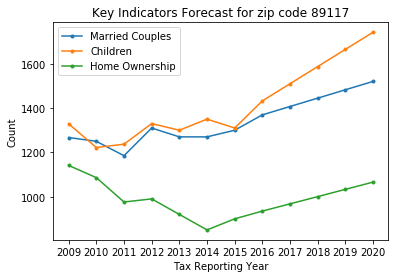

In [21]:
#Plot the projections for a sample zip code
sample_zip_code = '89117'
sample_list_train = x_train[:,0] == sample_zip_code
forecast_yrs = np.array([2016, 2017, 2018, 2019, 2020])

enc_1 = x_test_encode[x_test[:,0] == sample_zip_code,:-1]
x_forecast = np.column_stack((np.vstack((enc_1,enc_1,enc_1,enc_1,enc_1)),forecast_yrs))
y_forecast = np.column_stack((x_train[sample_list_train,:-1][0:5,:],forecast_yrs,
                              model.predict(x_forecast) * y_train_stdev + y_train_mean))    

sample_zip_train = np.hstack((x_train[sample_list_train],y_train[sample_list_train]))
sample_zip = np.vstack((sample_zip_train[np.argsort(sample_zip_train[:,2])],y_forecast))

plt.plot(sample_zip[:,2], sample_zip[:,3].astype(np.float), '.-', label='Married Couples')
plt.plot(sample_zip[:,2], sample_zip[:,4].astype(np.float), '.-', label='Children')
plt.plot(sample_zip[:,2], sample_zip[:,6].astype(np.float), '.-', label='Home Ownership')
plt.ylabel('Count')
plt.xlabel('Tax Reporting Year')
plt.legend()
plt.title("Key Indicators Forecast for zip code " + sample_zip_code)

plt.show

## Generating a Growth Index
Finally, we use the predictive model we've created to estimate output variables (# of returns, dependents, etc.) for all zip codes. This information is transformed into a growth index which can be used to inform life insurance companies of high potential zip codes for growth opportunities. The weights for each output variable in the growth index is based on the previously mentioned [Deloitte article](https://www2.deloitte.com/insights/us/en/industry/financial-services/marketing-life-insurance-in-a-digital-age.html).

In the output, we are reporting the top ten locations with highest growth potential.

In [22]:
#Generate 2020 predictions
x_forecast = np.column_stack((x_test_encode[:,:-1],np.ones(x_test_encode.shape[0])*2017))
y_forecast_norm = model.predict(x_forecast)

#Calculate growth index
growth_factors = [0.24, 0.28, 0.24, 0.24]
y_test_growth = np.sum(np.multiply(y_test_norm,growth_factors),axis=1)

y_forecast_growth = np.sum(np.multiply(y_forecast_norm,growth_factors),axis=1)

growth_index = np.column_stack((x_test[:,0:2],np.round(y_forecast_growth - y_test_growth, 3)))
growth_index = growth_index[np.argsort(-growth_index[:,2].astype(np.float))]

print("Top 10 Locations with Growth Potential:")
print("")
print("Zip Code - Growth Index")
print(growth_index[0:10,[0,2]])

Top 10 Locations with Growth Potential:

Zip Code - Growth Index
[['89117' '0.378']
 ['89031' '0.313']
 ['89123' '0.311']
 ['89130' '0.298']
 ['89147' '0.294']
 ['89143' '0.282']
 ['89128' '0.276']
 ['89115' '0.273']
 ['89002' '0.267']
 ['89523' '0.258']]
